In [313]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_points = 250 # Number of time points
time = np.arange(n_points)

# Generate base binary time series using Bernoulli distribution
X1 = np.random.binomial(1, 0.6, n_points)
X2 = np.zeros(n_points)
X3 = np.zeros(n_points)

# Introduce causal relationships
for t in range(1, n_points):
    # X2 is more likely to happen if X1 happened in the previous step
    X2[t] = np.random.binomial(1, 0.95 * X1[t-1])
    # X3 is more likely to happen if X2 happened in the previous step
    X3[t] = np.random.binomial(1, 0.95 * X2[t-1] )


#print(X1)

X1 = [time[i] for i in range(len(X1)) if X1[i] > 0]
X2 = [time[i] + 0.1 for i in range(len(X2)) if X2[i] > 0]
X3 = [time[i] + 0.2 for i in range(len(X3)) if X3[i] > 0]

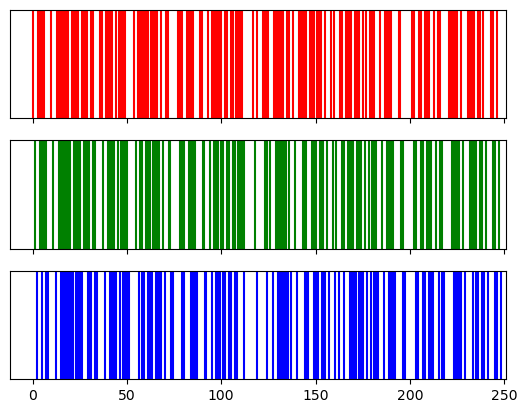

In [314]:
def _plot_tick_bars(timestamps_i, ax, color):
    for t in timestamps_i:
        ax.axvline(x=t, color = color)
    # ax.set_title(label, fontsize=20)
    ax.get_yaxis().set_visible(False)
def _plot_tick_bars_causes(timestamps_i, ax, cause):
    colors = ['red', 'green', 'blue']
    for idx, t in enumerate(timestamps_i):
        ax.axvline(x=t, color = colors[cause[idx]])
    ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

In [315]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    device = "cuda"
else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"
    

In [316]:
import torch 

class ProbRNN(nn.Module):
    def __init__(self, memory_size):
        super().__init__()

        self.memory_size = memory_size
        self.linear = nn.Sequential(nn.Linear(self.memory_size, 64), nn.Tanh())
        self.lstm = nn.LSTM(input_size = 64, hidden_size = 128, num_layers = 1, batch_first = True)
        self.linear_mu = nn.Sequential(nn.Linear(128, self.memory_size))
        self.linear_std = nn.Sequential(nn.Linear(128, self.memory_size))
        self.linear_gmm_weights = nn.Sequential(nn.Linear(128, self.memory_size), nn.Softmax(dim = 1))
        

    def forward(self, x):

      x = self.linear(x)
      x, _ = self.lstm(x)
      mu = self.linear_mu(x)
      # print(mu)
      std = self.linear_std(x)
      std = torch.exp(std)
      gmm_weights = self.linear_gmm_weights(x)


      mix_dist = self.build_distrib(mu, std, gmm_weights)

      new_X = self.sample(mu, std)
      # X = mu + std
      log_prob = mix_dist.log_prob(new_X)

    
      return new_X, log_prob


    def build_distrib(self, mus, stds, gmm_weights):
      
      ### This should not work if batch_size != 1. Yet to decide how to deal with this behaviour.
      
      component_dist = torch.distributions.Normal(mus.T, stds.T)
      mix_weight = torch.distributions.Categorical(gmm_weights.T)
      mix_dist = torch.distributions.MixtureSameFamily(mix_weight, component_dist)
      self.mix_dist = mix_dist
      

      return mix_dist

    def sample(self, mu, std):
      size = (std.size(0),)

      X =  mu + self.mix_dist.sample(size)*std

      return X


In [317]:
rede = ProbRNN(memory_size=10)

X = torch.rand(size = (20,10))

new_X, logp = rede(X)

In [318]:
X1_ = torch.tensor(X1.copy(), dtype = torch.float32)
X2_ = torch.tensor(X2.copy(), dtype = torch.float32)
X3_ = torch.tensor(X3.copy(), dtype = torch.float32)
processes = [X1_, X2_, X3_]

In [332]:
class GrangerMPP(nn.Module):

    def __init__(self, processes, memory_dim : int = 10):
        
        super().__init__()
        
        self.processes = processes
        self.memory_dim = memory_dim
        self.n_processes = len(self.processes)
        self.GrangerMatrix = nn.Parameter(nn.Softmax(dim=1)(torch.Tensor(self.n_processes, self.n_processes)))# nn.Parameter(nn.Parameter(torch.Tensor(self.n_processes, self.n_processes))
        self.models = nn.ModuleList([ProbRNN(self.memory_dim) for i in range(self.n_processes)])
        self.sweep_dict = self.make_sweep_dict()
        self.optimizers = [torch.optim.Adam(list(self.models[i].parameters()) + [self.GrangerMatrix], lr=1e-4, weight_decay = 1e-4) for i in range(self.n_processes)]

    def e_step(self, in_weights: torch.Tensor, points_current_pp):
        
        """
        Return the causes for each event of the current_p
        
        """
        
        n = len(points_current_pp)
        rv = []
    
        for i in range(n):
            cause = F.gumbel_softmax(
                in_weights,
                hard = True
            )
            cause = torch.argmax(cause, dim = 0)
            rv.append(cause)
    
        
        
        return rv

    def em_step(self, n_steps):
        dic = {}
        
        for i in range(self.n_processes):
            dic[i] = []
        
        for step in range(n_steps):
            self.causes = []
            for i_proc in range(self.n_processes):
                rv = self.e_step(
                    self.GrangerMatrix[i_proc],
                    self.processes[i_proc]
                )
                self.causes.append(rv)
            
            
            for i_proc in range(self.n_processes):
                
                causes_to_ith = self.causes[i_proc] ## causes of ith_proc
                
                for j, cause_to_ith in enumerate(causes_to_ith):
                    
                    cause_to_ith = cause_to_ith.item()
                    effect_j_on_i = self.sweep_dict[i_proc][cause_to_ith]
                    
                    if (cause_to_ith == i_proc) and j>=self.memory_dim:
                        X_to_pass = processes[i_proc][j - self.memory_dim : j]
                        X_to_pass = X_to_pass.flip(dims = (0,)) - X_to_pass[0]
                        reg_term = len(processes[cause_to_ith]) #len(processes[i_proc])*len(processes[cause_to_ith])
                        loss = self.m_step(i_proc, X_to_pass.unsqueeze(0), reg_term) 
                        dic[i_proc].append(loss)
                    
                    elif len(effect_j_on_i) > j:
                        X_to_pass = effect_j_on_i[j]
                        reg_term = 1 #len(processes[cause_to_ith])*len(processes[i_proc])
                        loss = self.m_step(i_proc, X_to_pass.unsqueeze(0), reg_term)
                        dic[i_proc].append(loss)
                
                if (step + 1) % 25 == 0 or step == 0:
                                print(f'Step: {step + 1}, Model: {i_proc}, Loss: {loss}')
                    
    
        return dic

    def m_step(self, i_proc, X, reg_term):
        model = self.models[i_proc]
        
        self.optimizers[i_proc].zero_grad()
        z, loss = model(X)
        loss = -loss.sum()/reg_term
        
        if not (torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            self.optimizers[i_proc].step()
        else:
            print(f'NaN found in epoch: {step}')    

        return loss.item()

    def make_sweep_dict(self):
        
        dic = {}
        for i in range(self.n_processes):
            target = processes[i]
            dic[i] = {}
            for j in range(self.n_processes):
                cause = self.processes[j]
                dic[i][j] = self.sweep(target, cause)
        return dic


    def sweep(self, pa, pc):
      events = []
      for ia in pa:
        events.append((ia, 'a'))
      for ic in pc:
        events.append((ic, 'c'))
    
      lim = self.memory_dim
    
      events.sort()
      mem = []
      ret = []
      for [t, e] in events:
    
        if e == 'c':
          if len(mem) >= lim:
            mem.pop(0)
          mem.append(t)
    
        if e == 'a':

          if len(mem) < lim:
            continue
          
          pp = []
          for tc in mem:
            pp.append(t - tc)
          ret.append(pp)
    
      return torch.tensor(ret, dtype = torch.float)

In [333]:
mpp = GrangerMPP(processes, memory_dim = 5)
l = mpp.em_step(n_steps = 50)

Step: 1, Model: 0, Loss: 0.033232204616069794
Step: 1, Model: 1, Loss: -1.565876841545105
Step: 1, Model: 2, Loss: -1.4534597396850586
Step: 25, Model: 0, Loss: -0.32479536533355713
Step: 25, Model: 1, Loss: -189.95802307128906
Step: 25, Model: 2, Loss: -181.42117309570312


ValueError: Expected parameter loc (Tensor of shape (5, 1)) of distribution Normal(loc: torch.Size([5, 1]), scale: torch.Size([5, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<PermuteBackward0>)

In [326]:
mpp.GrangerMatrix.detach().cpu().numpy()

array([[0.3225913 , 0.34575263, 0.33165604],
       [0.3349241 , 0.35039994, 0.31467596],
       [0.3320659 , 0.30715004, 0.36078402]], dtype=float32)

In [327]:
mpp.GrangerMatrix[0]

tensor([0.3226, 0.3458, 0.3317], grad_fn=<SelectBackward0>)

Len of losses: [7219, 6859, 6488]


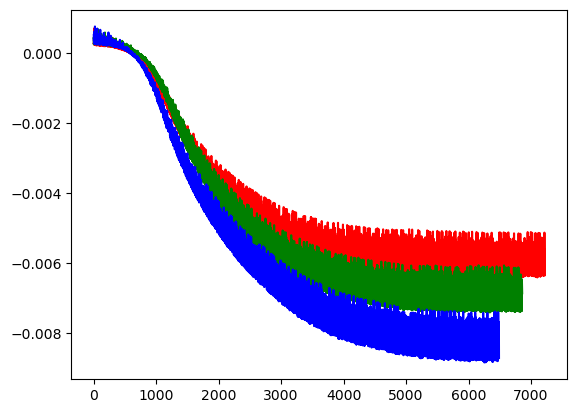

In [328]:
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(l[i], color = colors[i])

t = [len(l[i]) for i in range(3)]

print(f'Len of losses: {t}')

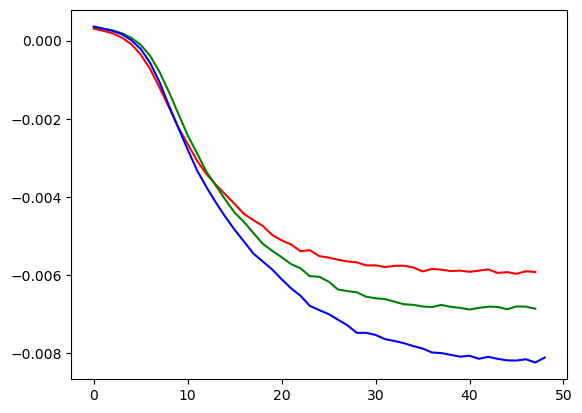

In [329]:
final = []
for proc in range(3):
    proc_size = len(processes[proc])
    loss_size = len(l[proc])
    temp = [ sum(l[proc][i:i + proc_size])/proc_size for i in range(0, loss_size - proc_size, proc_size)]
    final.append(temp)

colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(final[i], color = colors[i])

In [40]:
# colors = ['red', 'green', 'blue']
# for i in range(3):
#     plt.plot(final[i], color = colors[i])
 

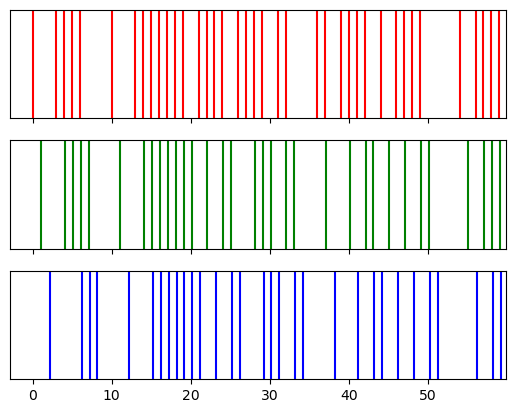

In [289]:
fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

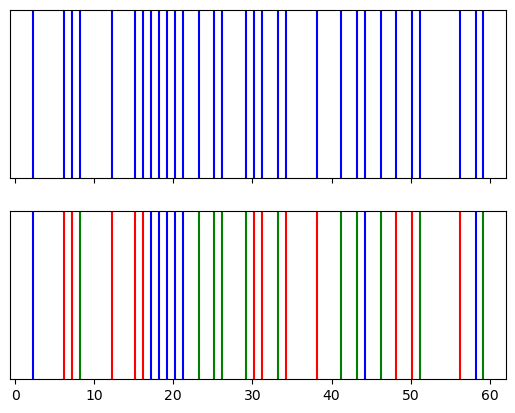

In [292]:
fig, ax = plt.subplots(nrows=2, sharex = True)
colors = ['red', 'green', 'blue']
idx = 2
proc_to_plot = processes[idx].detach().cpu().numpy()
_plot_tick_bars(proc_to_plot, ax[0], color = colors[idx])
_plot_tick_bars_causes(proc_to_plot, ax[1], cause = mpp.causes[idx])


In [295]:
mpp.GrangerMatrix.softmax(dim = 1).detach().cpu().numpy()

array([[0.32207322, 0.32876953, 0.34915727],
       [0.31930473, 0.31953308, 0.36116222],
       [0.32441628, 0.32875478, 0.3468289 ]], dtype=float32)

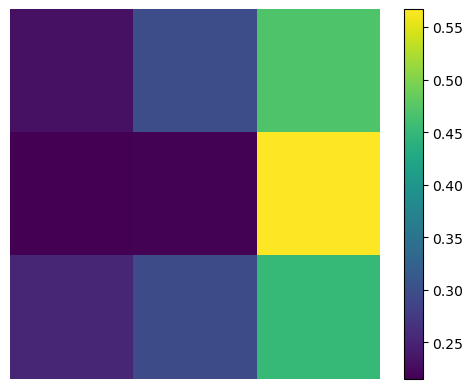

In [284]:
X = mpp.GrangerMatrix.detach().cpu().numpy()
X = (X.T/X.sum(axis = 1)).T
plt.imshow(X)
plt.axis('off')
plt.colorbar()

In [219]:
mpp.GrangerMatrix.softmax(dim = 1).detach().cpu().numpy()

array([[0.32807624, 0.3326895 , 0.33923426],
       [0.3360279 , 0.32100937, 0.3429627 ],
       [0.3106595 , 0.35641298, 0.3329275 ]], dtype=float32)

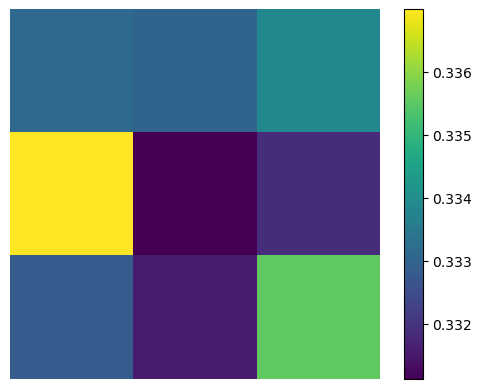

In [173]:
s = mpp.GrangerMatrix.softmax(dim = 1).detach().cpu().numpy()

plt.imshow(s)
plt.axis('off')
plt.colorbar()

In [134]:
torch.unique(torch.tensor(mpp.causes[idx]), return_counts = True)

(tensor([0, 1, 2]), tensor([50, 52, 51]))